In [38]:
import numpy as np
import pandas as pd
import statsmodels as sm
import statsmodels.api as smpi
import matplotlib.pyplot as plt

In [61]:
data = smpi.datasets.co2.load_pandas()
data

<class 'statsmodels.datasets.utils.Dataset'>

In [62]:
y = data.data
y

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


In [63]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


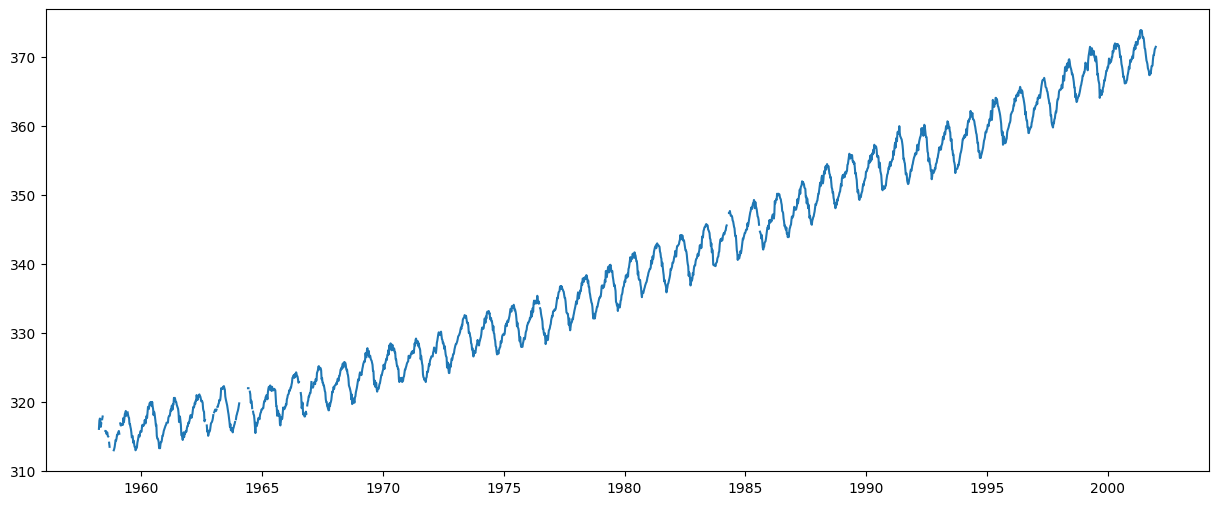

In [64]:
plt.figure(figsize=(15,6))
plt.plot(y['co2'])
plt.show()

5

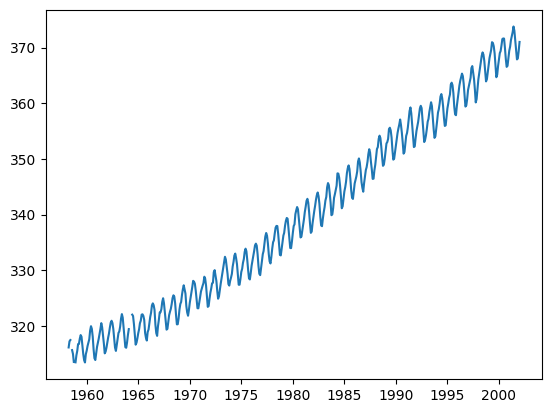

In [65]:
# 보간하기
tmp = y['co2'].resample('M').mean()
plt.plot(tmp)
tmp.isnull().sum()

In [66]:
# 추가 보간
y = tmp.bfill()

In [69]:
y

1958-03-31    316.100000
1958-04-30    317.200000
1958-05-31    317.433333
1958-06-30    315.625000
1958-07-31    315.625000
                 ...    
2001-08-31    369.425000
2001-09-30    367.880000
2001-10-31    368.050000
2001-11-30    369.375000
2001-12-31    371.020000
Freq: M, Name: co2, Length: 526, dtype: float64

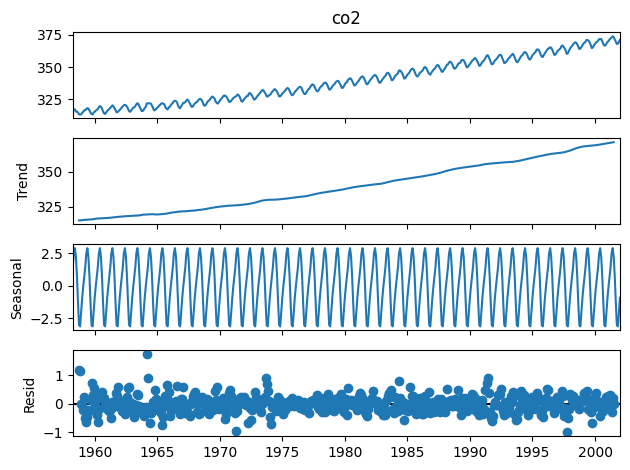

In [79]:
# 4 가지 요인 분해
from statsmodels.tsa.seasonal import seasonal_decompose

# 모델은 가법, 승법
result = seasonal_decompose(y, model='additive') # , freq= 가법 모델
result.plot()
plt.show()
# cycle은 없다

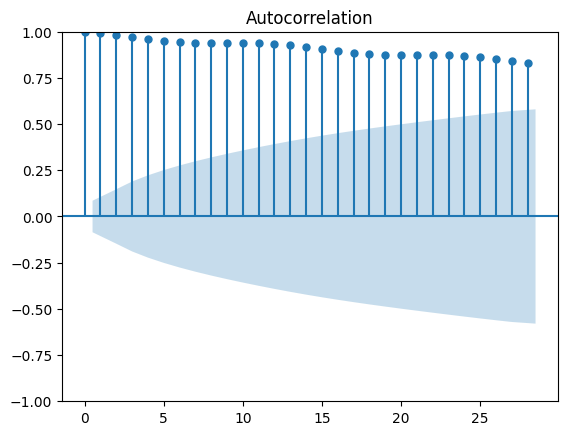

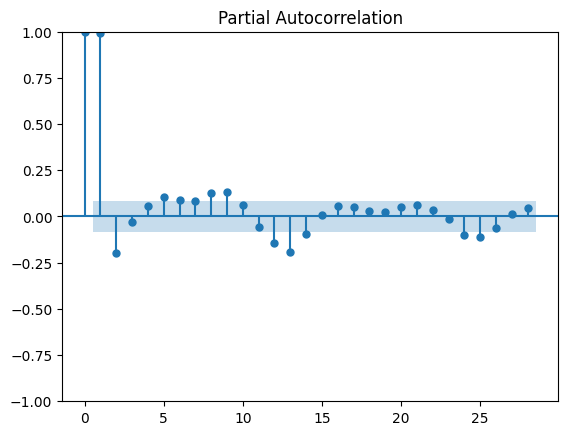

In [80]:
# ACF, PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y)
plot_pacf(y)
plt.show()

### p <- pacf가 cut off 일어나기 직전 2 시차(위의 차트에서)
### q <- acf가 점진적으로 감소하므로 0

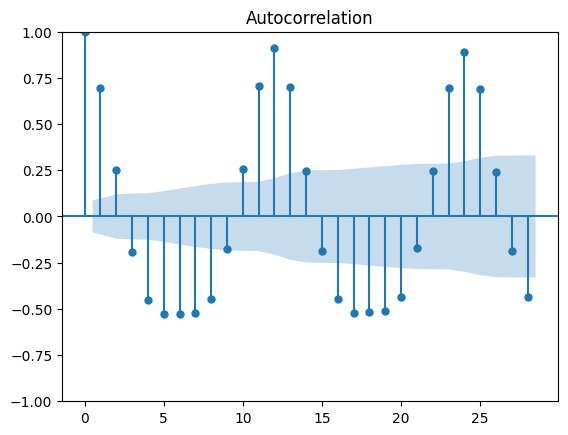

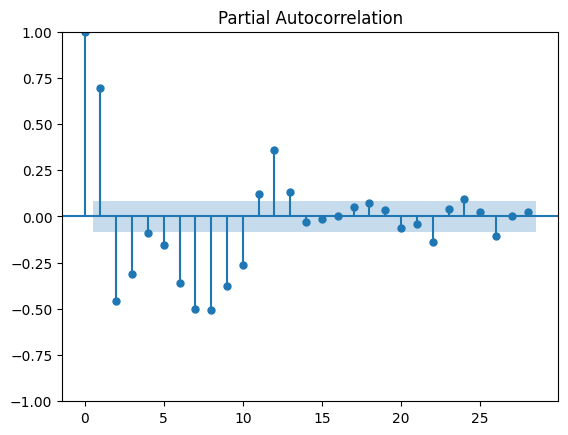

In [95]:
# 몇 번 차분해야 하는지(데이터가 정상상태가 될 때까지)
y_diff = y.diff(periods=1)[1:] # peridos=n : n차 차분
plot_acf(y_diff)
plot_pacf(y_diff)
plt.show()

<Axes: >

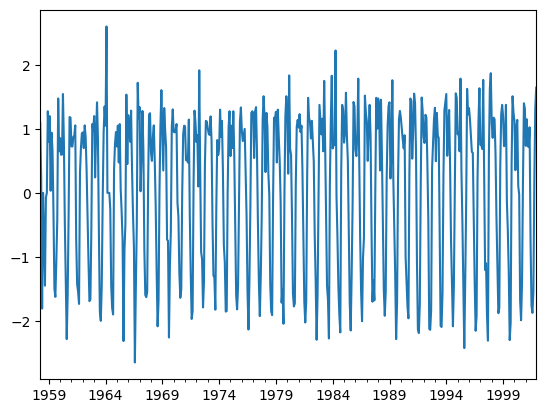

In [96]:
y_diff.plot()

### 차분해서 cut off가 일어나면 정상상태가 됨
### 차분해도 달라지는 게 없음 => 현재가 이미 정상상태였음

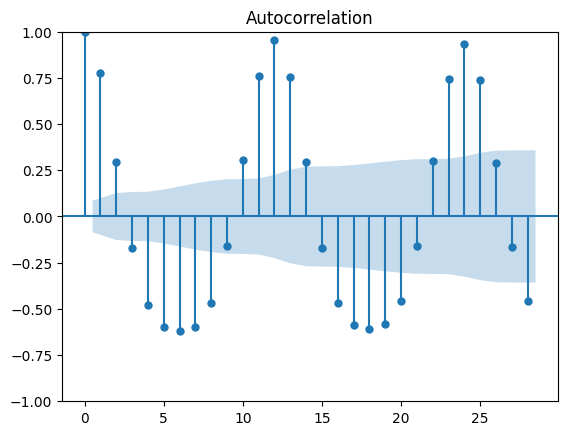

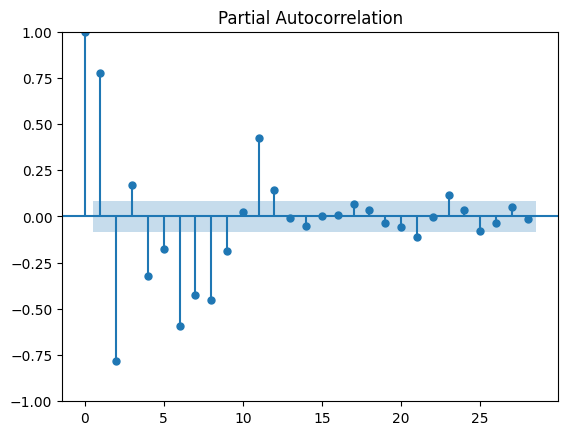

In [99]:
y_diff = y.diff(periods=2)[2:] # 차분해도 달라지는 게 없음. 1차 차분으로 정상화됨 
plot_acf(y_diff)
plot_pacf(y_diff)
plt.show()

<Axes: >

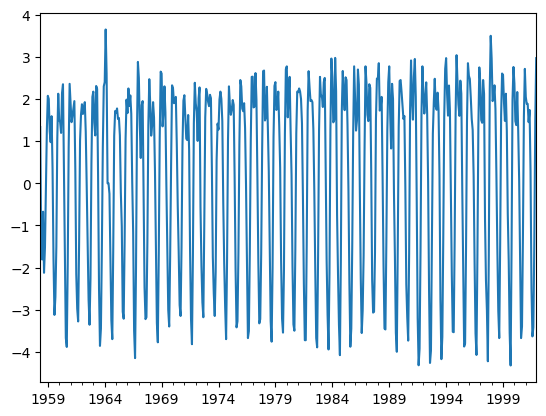

In [98]:
y_diff.plot()

### p, d, q = 2, 1, 0

In [200]:
from statsmodels.tsa.arima.model import ARIMA
# 예측기이긴 하지만, 장기적인 예측은 불가능하다
arima = ARIMA(y, order=(2,1,0))
arima_result = arima.fit()

In [201]:
# AIC / BIC / HQIC 가 낮을수록 좋다
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  526
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -599.722
Date:                Mon, 19 Jun 2023   AIC                           1205.443
Time:                        16:06:28   BIC                           1218.233
Sample:                    03-31-1958   HQIC                          1210.451
                         - 12-31-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0224      0.044     23.454      0.000       0.937       1.108
ar.L2         -0.4589      0.043    -10.666      0.000      -0.543      -0.375
sigma2         0.5738      0.039     14.761      0.000       0.498       0.650
===================================================================================
Ljung-Box (L1) (Q):                  11.56   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.00   Prob(JB):                         0.58
Heteroskedasticity (H):               0.83   Skew:                             0.10
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

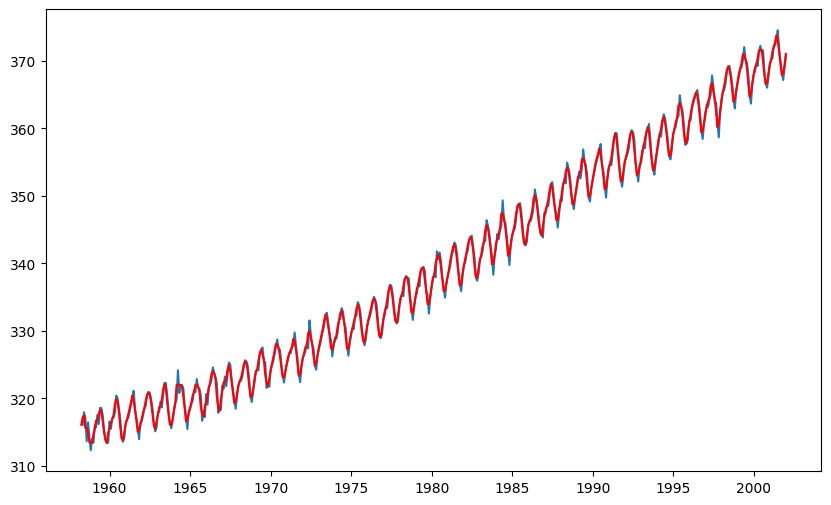

In [202]:
p = arima_result.predict()
plt.figure(figsize=(10,6))
plt.plot(p[1:])
plt.plot(y, color='red')
plt.show()

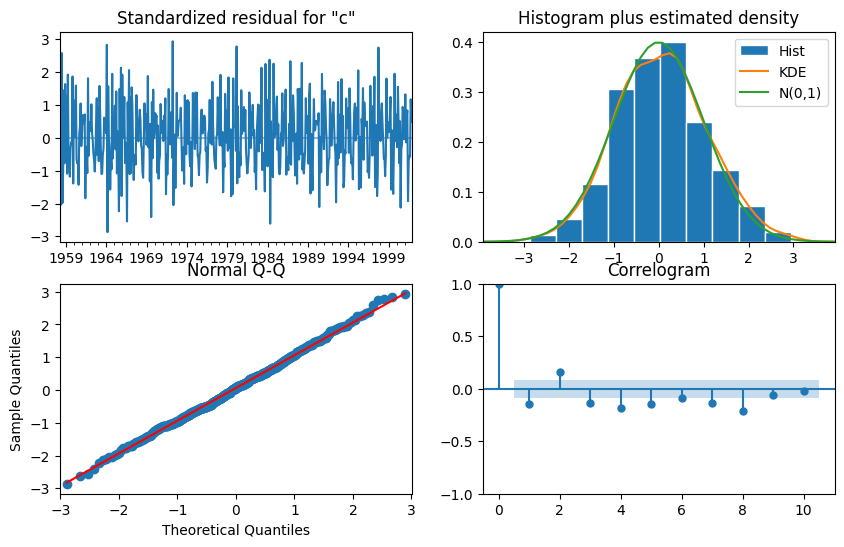

In [203]:
arima_result.plot_diagnostics(figsize=(10,6))
plt.show()
# white noise : 잔차가 랜덤하게 분포되어 있다
# kde : 정규분포에 가까울수록 좋다.
# N 

In [204]:
f = arima_result.forecast(steps=120)
f

2002-01-31    372.093734
2002-02-28    372.436558
2002-03-31    372.294285
2002-04-30    371.991494
2002-05-31    371.747221
                 ...    
2011-08-31    371.750253
2011-09-30    371.750253
2011-10-31    371.750253
2011-11-30    371.750253
2011-12-31    371.750253
Freq: M, Name: predicted_mean, Length: 120, dtype: float64

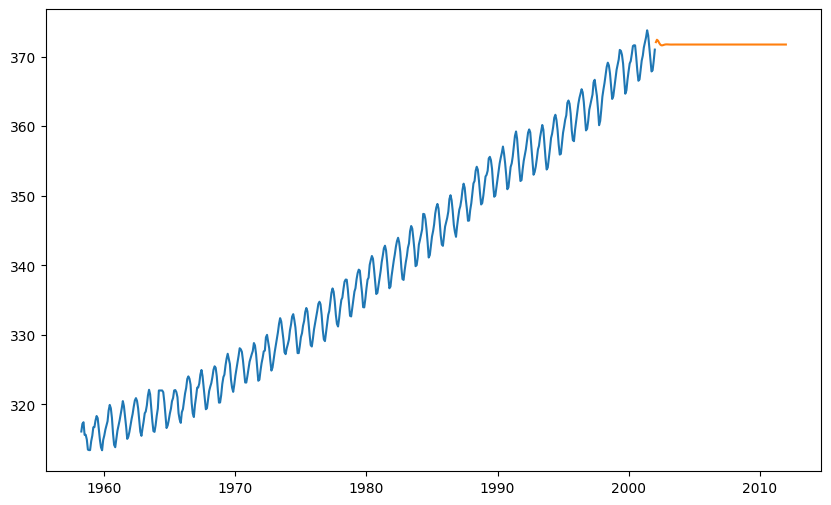

In [205]:
plt.figure(figsize=(10,6))
plt.plot(y)
plt.plot(f)
plt.show()

In [206]:
fore = arima_result.get_forecast(steps=120)
fore.predicted_mean
fore.conf_int() # 신뢰구간 95%

,lower co2,upper co2
2002-01-31,370.609032,373.578436
2002-02-28,369.086908,375.786209
2002-03-31,367.173585,377.414985
2002-04-30,365.452502,378.530487
2002-05-31,364.151514,379.342927
...,...,...
2011-08-31,335.130919,408.369588
2011-09-30,334.973326,408.527181
2011-10-31,334.816405,408.684102
2011-11-30,334.660148,408.840359


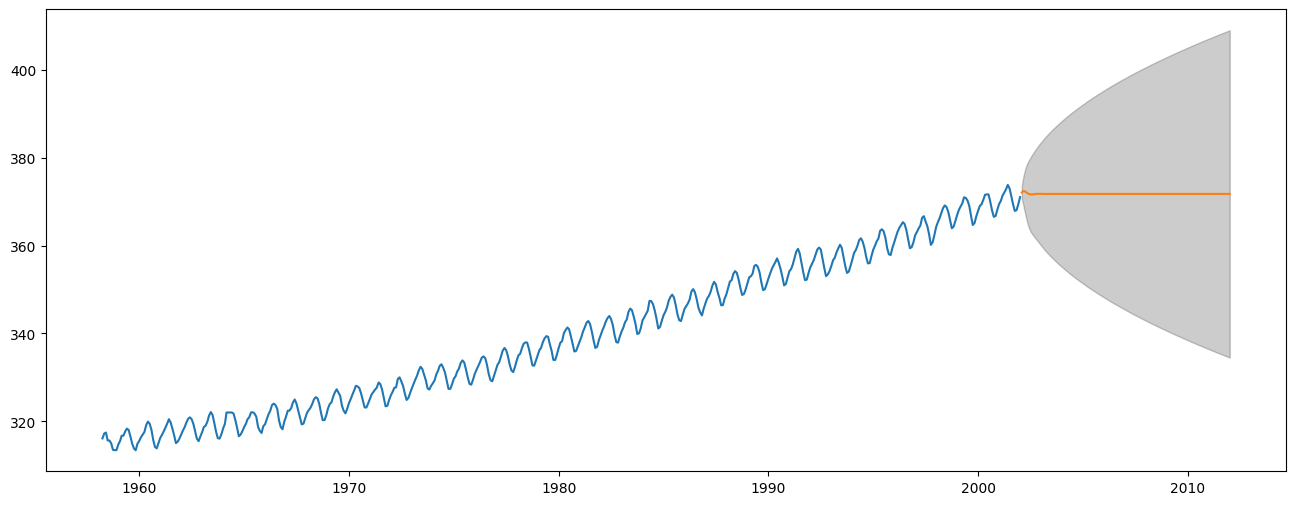

In [207]:
plt.figure(figsize=(16,6))
plt.plot(y)
plt.plot(fore.predicted_mean)

ci = fore.conf_int()
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='black', alpha=0.2)

plt.show()

c:\Users\PC\Bcode\myvenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


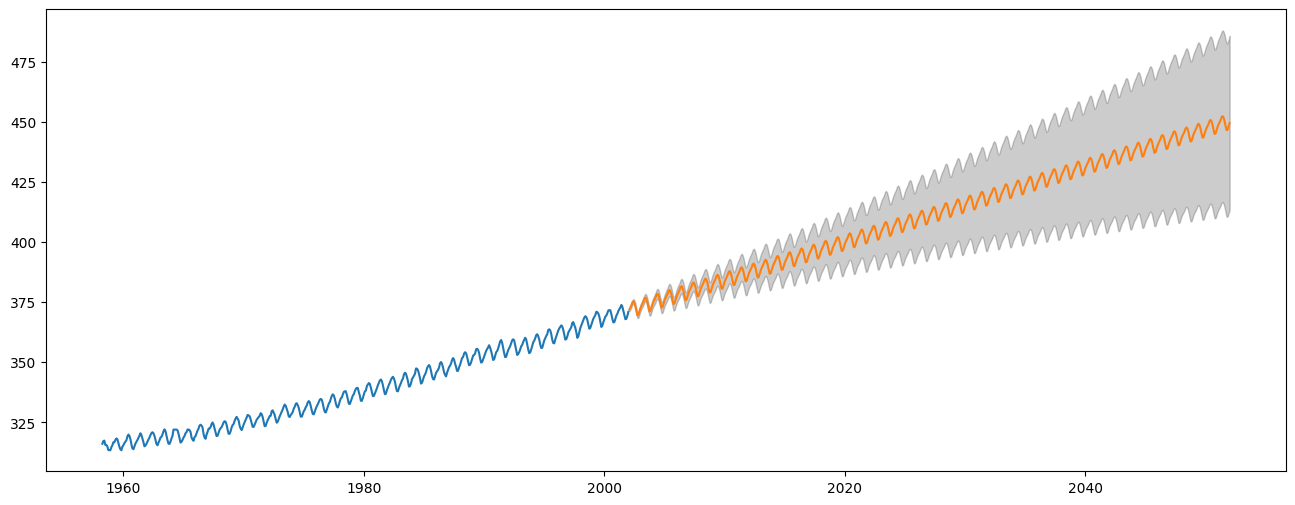

In [216]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima = SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,1,12), 
                enforce_stationarity=False, enforce_invertibility=False)
arima_result = arima.fit()
fore = arima_result.get_forecast(steps=600)

plt.figure(figsize=(16,6))
plt.plot(y)
plt.plot(fore.predicted_mean)

ci = fore.conf_int()
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='black', alpha=0.2)

plt.show()
